In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
import matplotlib.animation as animation
from collections import Counter 
sys.path.insert(1, '../../functions/')
from ParticlePlotFunctions import *
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load particle data
namefile = '../../input/particles/Beaching_200826.nc'
Traj = ReadTrajectories(namefile)
release_time = 293  #number of releases at specific location 
release_loc = 675   #number of release locations
total_particles = Traj['lon'].shape[0]

#thresholds:
distance_from_coast = 10 #in km
deploy_threshold = 0.8

In [ ]:
# Produce probability if no Stokes and no wind 
startlon = Traj['lon'][0:release_loc,0]
startlat = Traj['lat'][0:release_loc,0]
distance = Traj['distance'][:]
beaching_probability = np.zeros((release_loc))

for p in range(total_particles):
    index_loc = p%release_loc
    beached = np.where((distance[p,:] < distance_from_coast) & (distance[p,:] != 0))[0]
    if beached.any():
        beaching_probability[index_loc] += 1

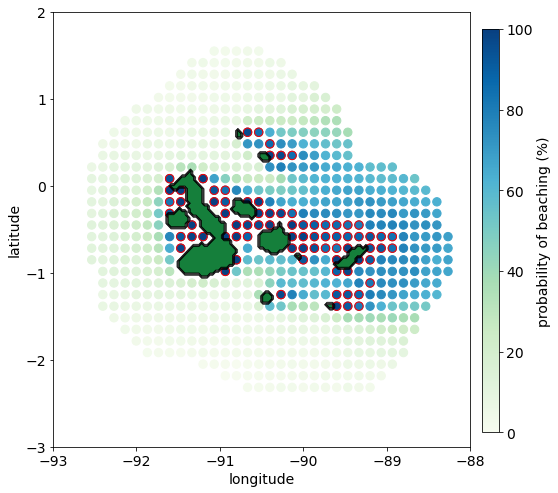

In [22]:
# Make figure if we have beaching probability for any island

galapagos_domain = [-93, -88, -3, 2]

Xfiles = '../../input/modelfields/MITgcm4km/RGEMS3_Surf_grid.nc'
dfile = Dataset(Xfiles)
mask0 = dfile.variables['maskC'][0,:,:]
mask1 = np.where(mask0==1, nan, 0)
lon = dfile.variables['XC'][:]
lat = dfile.variables['YC'][:]

deploy = np.zeros((release_loc))*nan        
deploy[np.where(beaching_probability/release_time>deploy_threshold)]=1

figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)

im = axs.scatter(startlon,startlat,s=70,
                 c=beaching_probability/release_time*100,
                 cmap='GnBu',
                 vmin=0,vmax=100) 
axs.scatter(startlon*deploy,startlat*deploy,s=70,
            facecolors='none',
            edgecolors='r') 
axs.contourf(lon,lat,mask1,cmap='Greens',vmin=-4,vmax=1)
axs.contour(lon, lat, mask0, colors='k', linestyles='-', linewidths = 0.5)
axs.set_xlabel('longitude')                 
axs.set_ylabel('latitude') 

axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])

cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('probability of beaching (%)')
plt.rcParams.update({'font.size': 14})

fig.subplots_adjust(wspace=0.0, hspace=0.0, right=0.85)

plt.savefig('probability_of_beaching.png', dpi=300)

In [28]:
# Specify at which island drifter is likely to beach

island = Traj['island'][:]
beaching_island = np.zeros((release_loc,release_time))
island_most = np.zeros((release_loc))

for p in range(total_particles):
    index_loc = p%release_loc
    index_release = math.floor(p/release_loc)
    beached = np.where((distance[p,:] < distance_from_coast) & (distance[p,:] != 0))[0]
    if beached.any():
        beaching_island[index_loc,index_release] = island[p,beached[0]]

for i in range(release_loc):
    if beaching_probability[i] > 0:
        occurence_count = Counter(beaching_island[i,:]) 
        most_frequent = occurence_count.most_common(2)
        if most_frequent[0][0]==0:
            island_most[i] = most_frequent[1][0]
        else:
            island_most[i] = most_frequent[0][0]
    

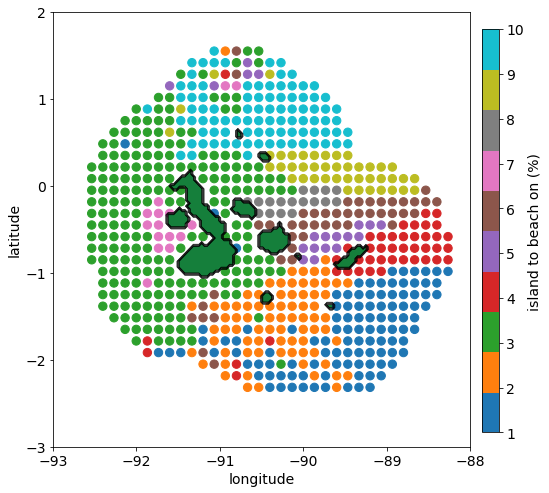

In [29]:
# Make figure to specify at which island drifter is likely to beach

galapagos_domain = [-93, -88, -3, 2]

Xfiles = '../../input/modelfields/MITgcm4km/RGEMS3_Surf_grid.nc'
dfile = Dataset(Xfiles)
mask0 = dfile.variables['maskC'][0,:,:]
mask1 = np.where(mask0==1, nan, 0)
lon = dfile.variables['XC'][:]
lat = dfile.variables['YC'][:]

figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)

im = axs.scatter(startlon,startlat,s=70,
                 c=island_most,
                 cmap='tab10',
                 vmin=1,vmax=10) 
axs.contourf(lon,lat,mask1,cmap='Greens',vmin=-4,vmax=1)
axs.contour(lon, lat, mask0, colors='k', linestyles='-', linewidths = 0.5)
axs.set_xlabel('longitude')                 
axs.set_ylabel('latitude') 

axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])

cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('island to beach on (%)')
plt.rcParams.update({'font.size': 14})

fig.subplots_adjust(wspace=0.0, hspace=0.0, right=0.85)
